In [2]:
pip install matminer scikit-learn pymatgen xgboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.0/809.0 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 37.5 MB/s eta 0:00:00
  Created wheel for bibtexparser: filename=bibtexparser-1.4.3-py3-none-any.whl size=435

In [3]:
# 1. Import libraries
import pandas as pd
import numpy as np
from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [4]:
# 2. Load and clean data
df = pd.read_csv("/content/elastic_properties_dataset.csv")

def extract_vrh(entry):
    try:
        parsed = ast.literal_eval(entry)
        return parsed.get('vrh', None)
    except:
        return None

df['shear_vrh'] = df['shear_modulus'].apply(extract_vrh)
df = df.dropna(subset=['shear_vrh', 'formula'])
df['shear_vrh'] = df['shear_vrh'].astype(float)
df = df[(df['shear_vrh'] > 0) & (df['shear_vrh'] < 500)]

In [5]:
# 3. Featurize chemical formulas
featurizer = ElementProperty.from_preset("magpie")
df['composition'] = df['formula'].apply(lambda x: Composition(x) if isinstance(x, str) else None)
df = df.dropna(subset=['composition'])

features = featurizer.featurize_dataframe(df, "composition", ignore_errors=True)
features = features.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

X = features.loc[:, features.columns.intersection(featurizer.feature_labels())]
y = features['shear_vrh']

/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/12219 [00:00<?, ?it/s]

In [6]:
# 4. Train/Validation/Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

# 5. Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [7]:
# 6. Evaluate on validation and test
val_preds = rf.predict(X_val)
test_preds = rf.predict(X_test)

print("Validation R^2:", r2_score(y_val, val_preds))
print("Test R^2:", r2_score(y_test, test_preds))
print("Test MAE:", mean_absolute_error(y_test, test_preds))
print("Test RMSE:", mean_squared_error(y_test, test_preds))


Validation R^2: 0.6446450444955094
Test R^2: 0.6432708290978983
Test MAE: 14.243460828565762
Test RMSE: 702.9415401855978


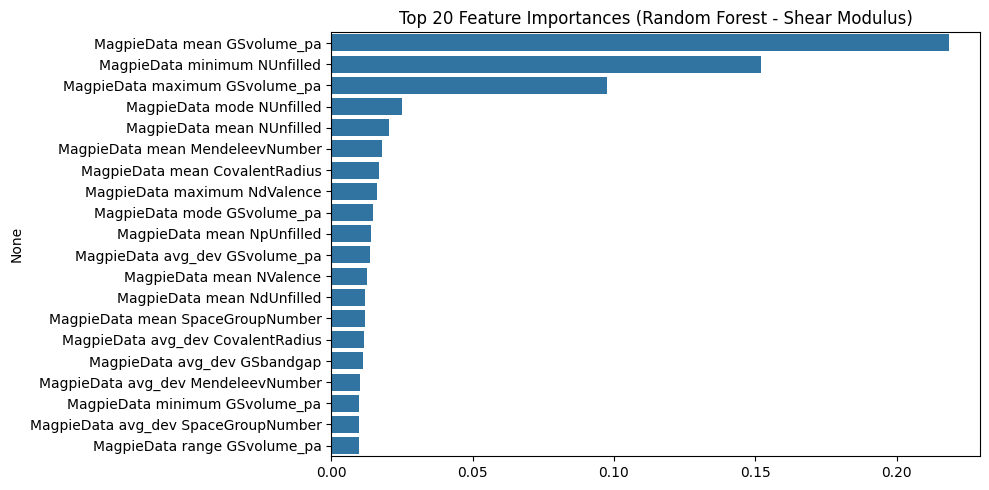

In [8]:
# 7. Feature Importance
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)[:20]
plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 20 Feature Importances (Random Forest - Shear Modulus)")
plt.tight_layout()
plt.show()

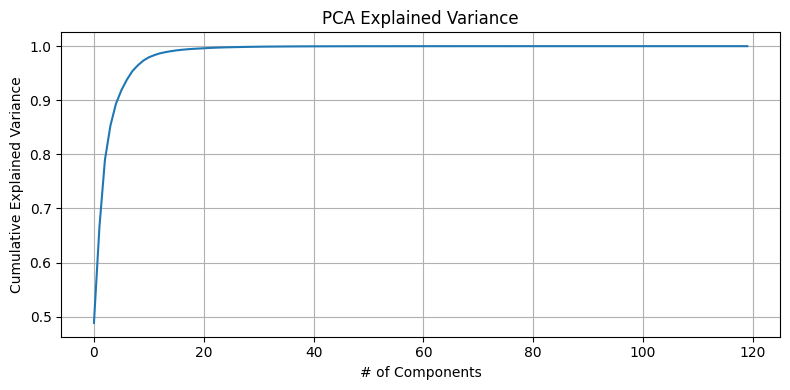

In [9]:
# 8. PCA Analysis
pca = PCA()
pca.fit(X)
explained = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,4))
plt.plot(explained)
plt.xlabel("# of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

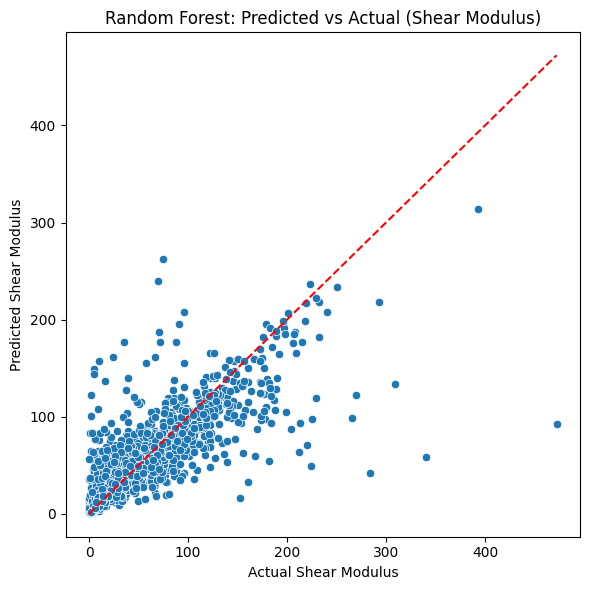

In [10]:
# 9. Predicted vs Actual Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=test_preds)
plt.xlabel("Actual Shear Modulus")
plt.ylabel("Predicted Shear Modulus")
plt.title("Random Forest: Predicted vs Actual (Shear Modulus)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()